# **Applications**

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/acubillosunal/UBM-DEEP-LEARNING-1/main/init.py
import init; init.init(force_download=False); 

In [2]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

2024-04-05 10:34:39.341869: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 10:34:39.345476: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 10:34:39.402571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 10:34:40.624200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.16.1'

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

/tmp/ipykernel_59904/3013929331.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
%matplotlib inline

## **Comparing XGBoost, RNN, and LSTM networks for improving stock price predictions**

In [7]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
import pandas_datareader.data as web
from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
%matplotlib inline

test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 30                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14

Definimos dos funciones definidas en el código: get_preds_lin_reg y get_mape. Se pasa un marco de datos (df) a la función get_preds_lin_reg, junto con la columna de destino (target_col), el número de valores retrasados a usar (N), el valor mínimo para las predicciones (pred_min) y el valor de compensación (offset). 

Según los N pasos de tiempo anteriores (t-1, t-2,…, t-N), se utiliza la regresión lineal para predecir los valores de la columna objetivo en cada paso de tiempo t. En otras palabras, solo predice valores para el marco de datos a partir del valor de desplazamiento. Esta función devuelve una lista de predicciones excluyendo los valores de compensación para la columna de destino.

Utilizando dos matrices (y_true e y_pred) como entrada, get_mape calcula el error porcentual absoluto medio (MAPE) entre los valores verdadero y predicho. El MAPE se devuelve como un porcentaje. La función get_preds_lin_reg predice valores en un marco de datos basándose en valores rezagados, mientras que la función get_mape calcula el error porcentual absoluto medio entre dos matrices.

In [10]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    
    regr = LinearRegression(fit_intercept=True)

    pred_list = []
    for i in range(offset, len(df['adj_close'])):
        X_train = np.array(range(len(df['adj_close'][i-N:i]))) 
        y_train = np.array(df['adj_close'][i-N:i]) 
        X_train = X_train.reshape(-1, 1)     
              
        y_train = y_train.reshape(-1, 1)
    #     print X_train.shape
    #     print y_train.shape
    #     print 'X_train = \n' + str(X_train)
    #     print 'y_train = \n' + str(y_train)
        regr.fit(X_train, y_train)            
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])  
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
pip install pandas_datareader --upgrade

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.2/315.2 kB 17.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 41.4 MB/s eta 0:00:00m eta 0:00:010:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 22.7 MB/s eta 0:00:00
  Created wheel for frozendict: filename=frozendict-2.4.1-cp311-cp311-linux_x86_64.whl size=15499 sha256=da788ac29567137a1f9b4fcb31cbaa9eefb72f07d7f971208481140b567d1cd3
  Stored in directory: /home/proci/.cache/pip/wheels/02/6e/a0/b90b693ddaaf2bde1efb47df2576175a1983aef24936f71694
  Created wheel for peewee: filename=peewee-3.17.1-cp311-cp311-linux_x86_64.whl size=272785 sha256=d0f7b8d

El código recupera datos históricos del mercado de valores para una empresa específica con el símbolo "TCS.NS". La fecha de inicio es el 1 de enero de 2010 y la fecha de finalización es el 31 de marzo de 2020. Utilizando la función web.DataReader del módulo pandas_datareader.data, recupera datos de acciones de la empresa especificada de la API de Yahoo Finance.

Se utiliza un marco de datos llamado df para almacenar los datos recuperados. Se agrega una nueva columna llamada "fecha" al marco de datos, que contiene los valores de índice del marco de datos (correspondientes a las fechas). Luego se reinicia para tener un nuevo índice secuencial, eliminando el anterior. La función head() muestra las primeras filas del marco de datos, lo que permite vislumbrar los datos bursátiles de la empresa especificada.

In [22]:
import yfinance as yf
import pandas as pd

main_company = 'TCS'  # Use only the ticker symbol

start = datetime(2010, 1, 1)
end = datetime(2020, 3, 31)

# Use yfinance to download data
df = yf.download(main_company, start=start, end=end)

# Add a 'date' column with the index (timestamps)
df['date'] = df.index

# Reset the index (optional, keeps the date as a column)
# df = df.reset_index(drop=True)

df.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,date
Date,,,,,,,
2013-11-01,35.000000,37.000000,32.099998,36.200001,33.839130,14667600,2013-11-01
2013-11-04,36.799999,36.799999,34.689999,35.349998,33.044563,1586600,2013-11-04
2013-11-05,35.110001,35.500000,34.820000,35.349998,33.044563,337700,2013-11-05
2013-11-06,35.610001,36.490002,35.610001,35.900002,33.558697,549600,2013-11-06
2013-11-07,36.799999,36.799999,34.119999,35.310001,33.007175,883700,2013-11-07


In [23]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'date'], dtype='object')

### **Cargue de la data**

In [24]:
# Convert Date column to datetime
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')


In [25]:
# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
# Get month of each sample
df['month'] = df['date'].dt.month
# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)
df.head(10)

,open,high,low,close,adj_close,volume,date,month
Date,,,,,,,,
2013-11-01,35.000000,37.000000,32.099998,36.200001,33.839130,14667600,2013-11-01,11
2013-11-04,36.799999,36.799999,34.689999,35.349998,33.044563,1586600,2013-11-04,11
2013-11-05,35.110001,35.500000,34.820000,35.349998,33.044563,337700,2013-11-05,11
2013-11-06,35.610001,36.490002,35.610001,35.900002,33.558697,549600,2013-11-06,11
2013-11-07,36.799999,36.799999,34.119999,35.310001,33.007175,883700,2013-11-07,11
2013-11-08,35.299999,35.459999,34.730000,34.950001,32.670654,488300,2013-11-08,11
2013-11-11,35.349998,35.349998,33.919998,34.240002,32.006958,430500,2013-11-11,11
2013-11-12,34.540001,34.540001,33.750000,33.990002,31.773262,331400,2013-11-12,11
2013-11-13,33.500000,34.500000,33.049999,34.150002,31.922829,419500,2013-11-13,11


Text(0, 0.5, 'USD')

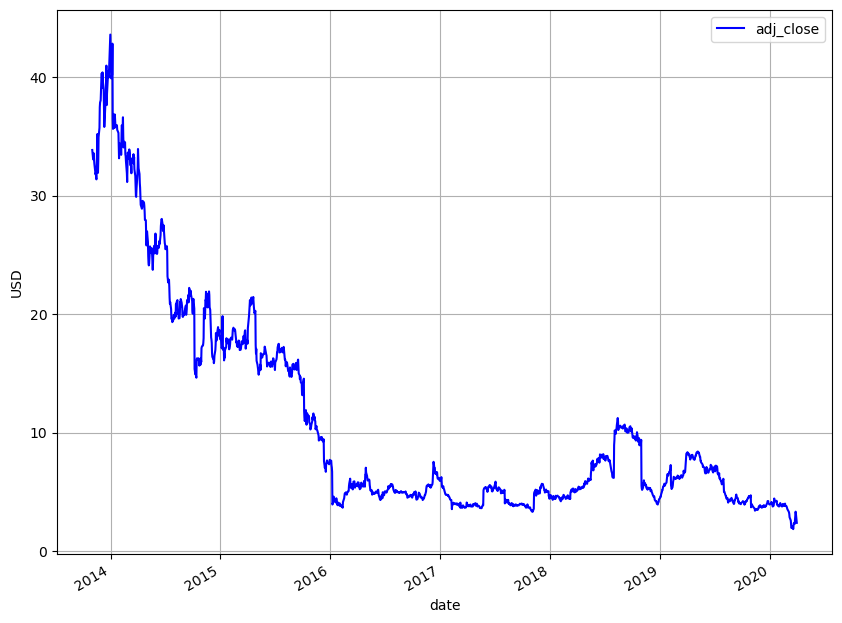

In [27]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [28]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

num_train = 968
num_cv = 322
num_test = 322


Este código divide un conjunto de datos en conjuntos de entrenamiento, validación cruzada (CV) y prueba. El primer paso es calcular los tamaños (número de filas) de cada conjunto de datos en función de las proporciones especificadas por CV_size y TEST_SIZE. Para obtener los tamaños respectivos, multiplica estas proporciones por la longitud total del conjunto de datos. Cada conjunto de datos tendrá una cierta cantidad de filas.

En el siguiente paso, el código extrae los subconjuntos correspondientes del marco de datos original (df). Los conjuntos de tren, CV y prueba se crean mediante operaciones de corte. num_train filas del marco de datos original forman el conjunto de trenes. Desde num_train hasta num_train+num_cv, el conjunto de CV contiene filas consecutivas. El conjunto train_cv combina los conjuntos train y CV, y contiene filas desde el principio hasta num_train+num_cv.

Finalmente, el conjunto de prueba contiene las filas restantes del marco de datos original, comenzando con num_train+num_cv. Para mostrar el número de filas y columnas en cada conjunto de datos, el código imprime las formas de cada conjunto de datos. El código calcula los tamaños de los conjuntos de entrenamiento, validación cruzada y prueba en función de proporciones específicas y luego divide el conjunto de datos original en estos subconjuntos. Se pueden analizar y modelar porciones separadas de los datos por separado.

In [29]:
# Split into train, cv, and test
train = df[:num_train].copy()
cv = df[num_train:num_train+num_cv].copy()
train_cv = df[:num_train+num_cv].copy()
test = df[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

train.shape = (968, 8)
cv.shape = (322, 8)
train_cv.shape = (1290, 8)
test.shape = (322, 8)


### **EDA**

Text(0, 0.5, 'USD')

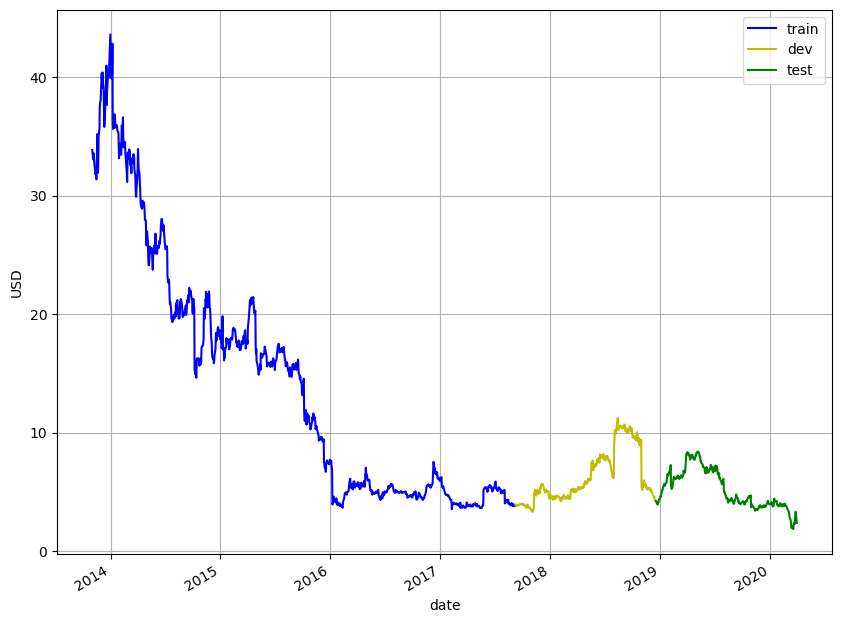

In [30]:
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

### **Prediction Usando regresión Lineal**

Con este código, puede visualizar los precios de cierre ajustados de una acción a lo largo del tiempo para los conjuntos de entrenamiento, validación cruzada (dev) y prueba. Para empezar, la figura de la trama tiene un ancho de 10 unidades y una altura de 8 unidades. Con train.plot(), traza los precios de cierre ajustados para el conjunto de entrenamiento. Los datos de la columna "fecha" se utilizan para el eje x y los datos de la columna "adj_close" se utilizan para el eje y.

Para mejorar la visualización, el gráfico tiene un estilo con una línea azul continua ('b-') y líneas de cuadrícula. Luego superpone el gráfico con los precios de cierre ajustados para el conjunto de validación cruzada (cv.plot()) y el conjunto de prueba (test.plot()). La validación cruzada se representa como una línea amarilla continua (“y-”) y la prueba como una línea verde continua (“g-”). Utilizando los mismos ejes de trazado (ax=ax), ambos trazados se pueden mostrar juntos. Muestra etiquetas para los diferentes conjuntos en la leyenda de la trama: "train" para el conjunto de entrenamiento, "dev" (abreviatura de desarrollo) para el conjunto de validación cruzada y "test" para el conjunto de prueba.

Como paso final, establece la etiqueta del eje x como "fecha" para indicar el período de tiempo y la etiqueta del eje y como "USD" para indicar la moneda de los precios de cierre ajustados. Se genera un gráfico único para comparar los precios de cierre ajustados de una acción a lo largo del tiempo para los conjuntos de entrenamiento, validación cruzada y prueba.

In [31]:
RMSE = []
R2 = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'adj_close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    R2.append(r2_score(cv['adj_close'], est_list))
    mape.append(get_mape(cv['adj_close'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(mape))
cv.head()

RMSE = [0.3376114655909, 0.48083760620356986, 0.4104312571924119, 0.40903980175088955, 0.42421039199852406, 0.43196967482060744, 0.4462007746348436, 0.4584797123419584, 0.4693220721220834, 0.48163663604928036, 0.49666645831218265, 0.513202139992686, 0.5302163875906839, 0.5457218726152726, 0.5592894172790482, 0.5730267786806507, 0.586263740648113, 0.5977073213843581, 0.6084756534824644, 0.6183232554412114, 0.628104923981505, 0.6372597663561876, 0.6454803477085218, 0.6528744360046344, 0.6604334950203754, 0.6685196077481131, 0.6768453914936859, 0.6856361587287212, 0.694711402612652, 0.7041960384004811]
R2 = [0.9763435308472004, 0.9520142372103155, 0.9650379889427213, 0.965274645462636, 0.9626510706569607, 0.9612722675779247, 0.9586784893905766, 0.95637295518842, 0.9542851279088206, 0.951854624428296, 0.9488029175115668, 0.9453371252998839, 0.94165255503789, 0.9381900671957611, 0.9350784688984004, 0.93185007444088, 0.9286651718415875, 0.9258531507374885, 0.9231574158138927, 0.9206500400879

,open,high,low,close,adj_close,volume,date,month,est_N1,est_N2,...,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
Date,,,,,,,,,,,,,,,,,,,,,
2017-09-07,4.14,4.22,4.12,4.20,3.926087,113300,2017-09-07,9,3.841957,3.841957,...,3.775988,3.770452,3.759821,3.782821,3.714078,3.657243,3.626877,3.609077,3.593733,3.580475
2017-09-08,4.20,4.25,4.08,4.23,3.954130,163600,2017-09-08,9,3.926087,4.010217,...,3.786359,3.782228,3.775746,3.764430,3.785402,3.718421,3.662484,3.631779,3.613119,3.596829
2017-09-11,4.22,4.23,4.16,4.18,3.907391,114300,2017-09-11,9,3.954130,3.982174,...,3.812756,3.798131,3.792853,3.785395,3.773343,3.792341,3.726880,3.671693,3.640610,3.621090
2017-09-12,4.18,4.28,4.08,4.10,3.832609,184800,2017-09-12,9,3.907391,3.860652,...,3.814714,3.815127,3.800390,3.794540,3.786617,3.774278,3.791808,3.728076,3.673903,3.642773
2017-09-13,4.09,4.24,4.09,4.15,3.879348,184600,2017-09-13,9,3.832609,3.757826,...,3.811509,3.804201,3.804454,3.790205,3.784374,3.776522,3.764378,3.780973,3.719237,3.666389


Text(0, 0.5, 'R2')

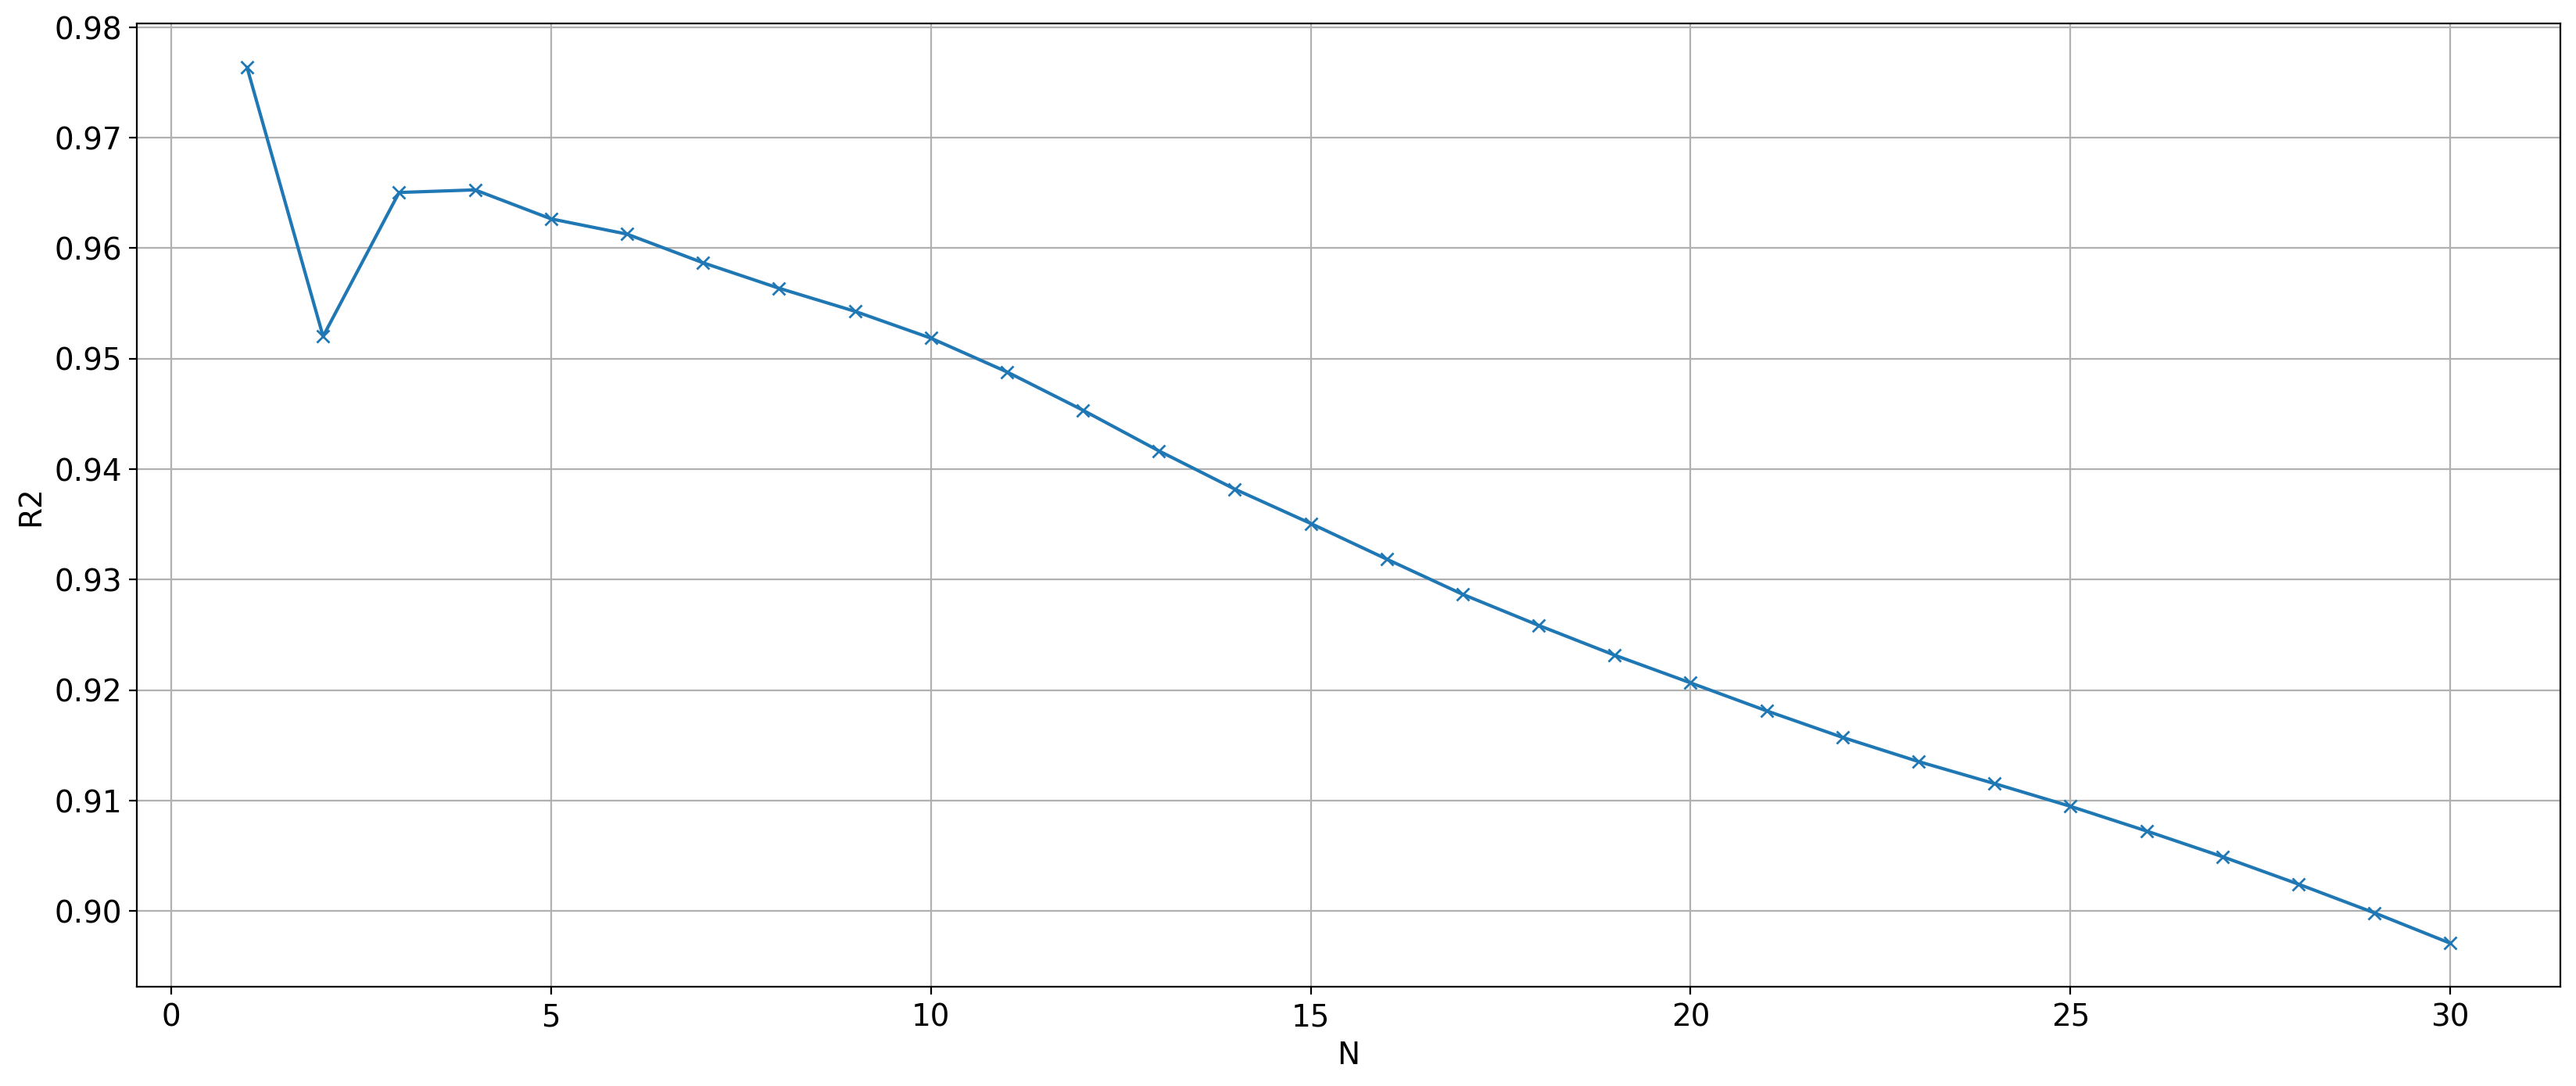

In [33]:
# Plot R2 versus N. Note for R2 larger better. 
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(20, 8), dpi=200)
plt.plot(range(1, Nmax+1), R2, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('R2')

Text(0, 0.5, 'RMSE')

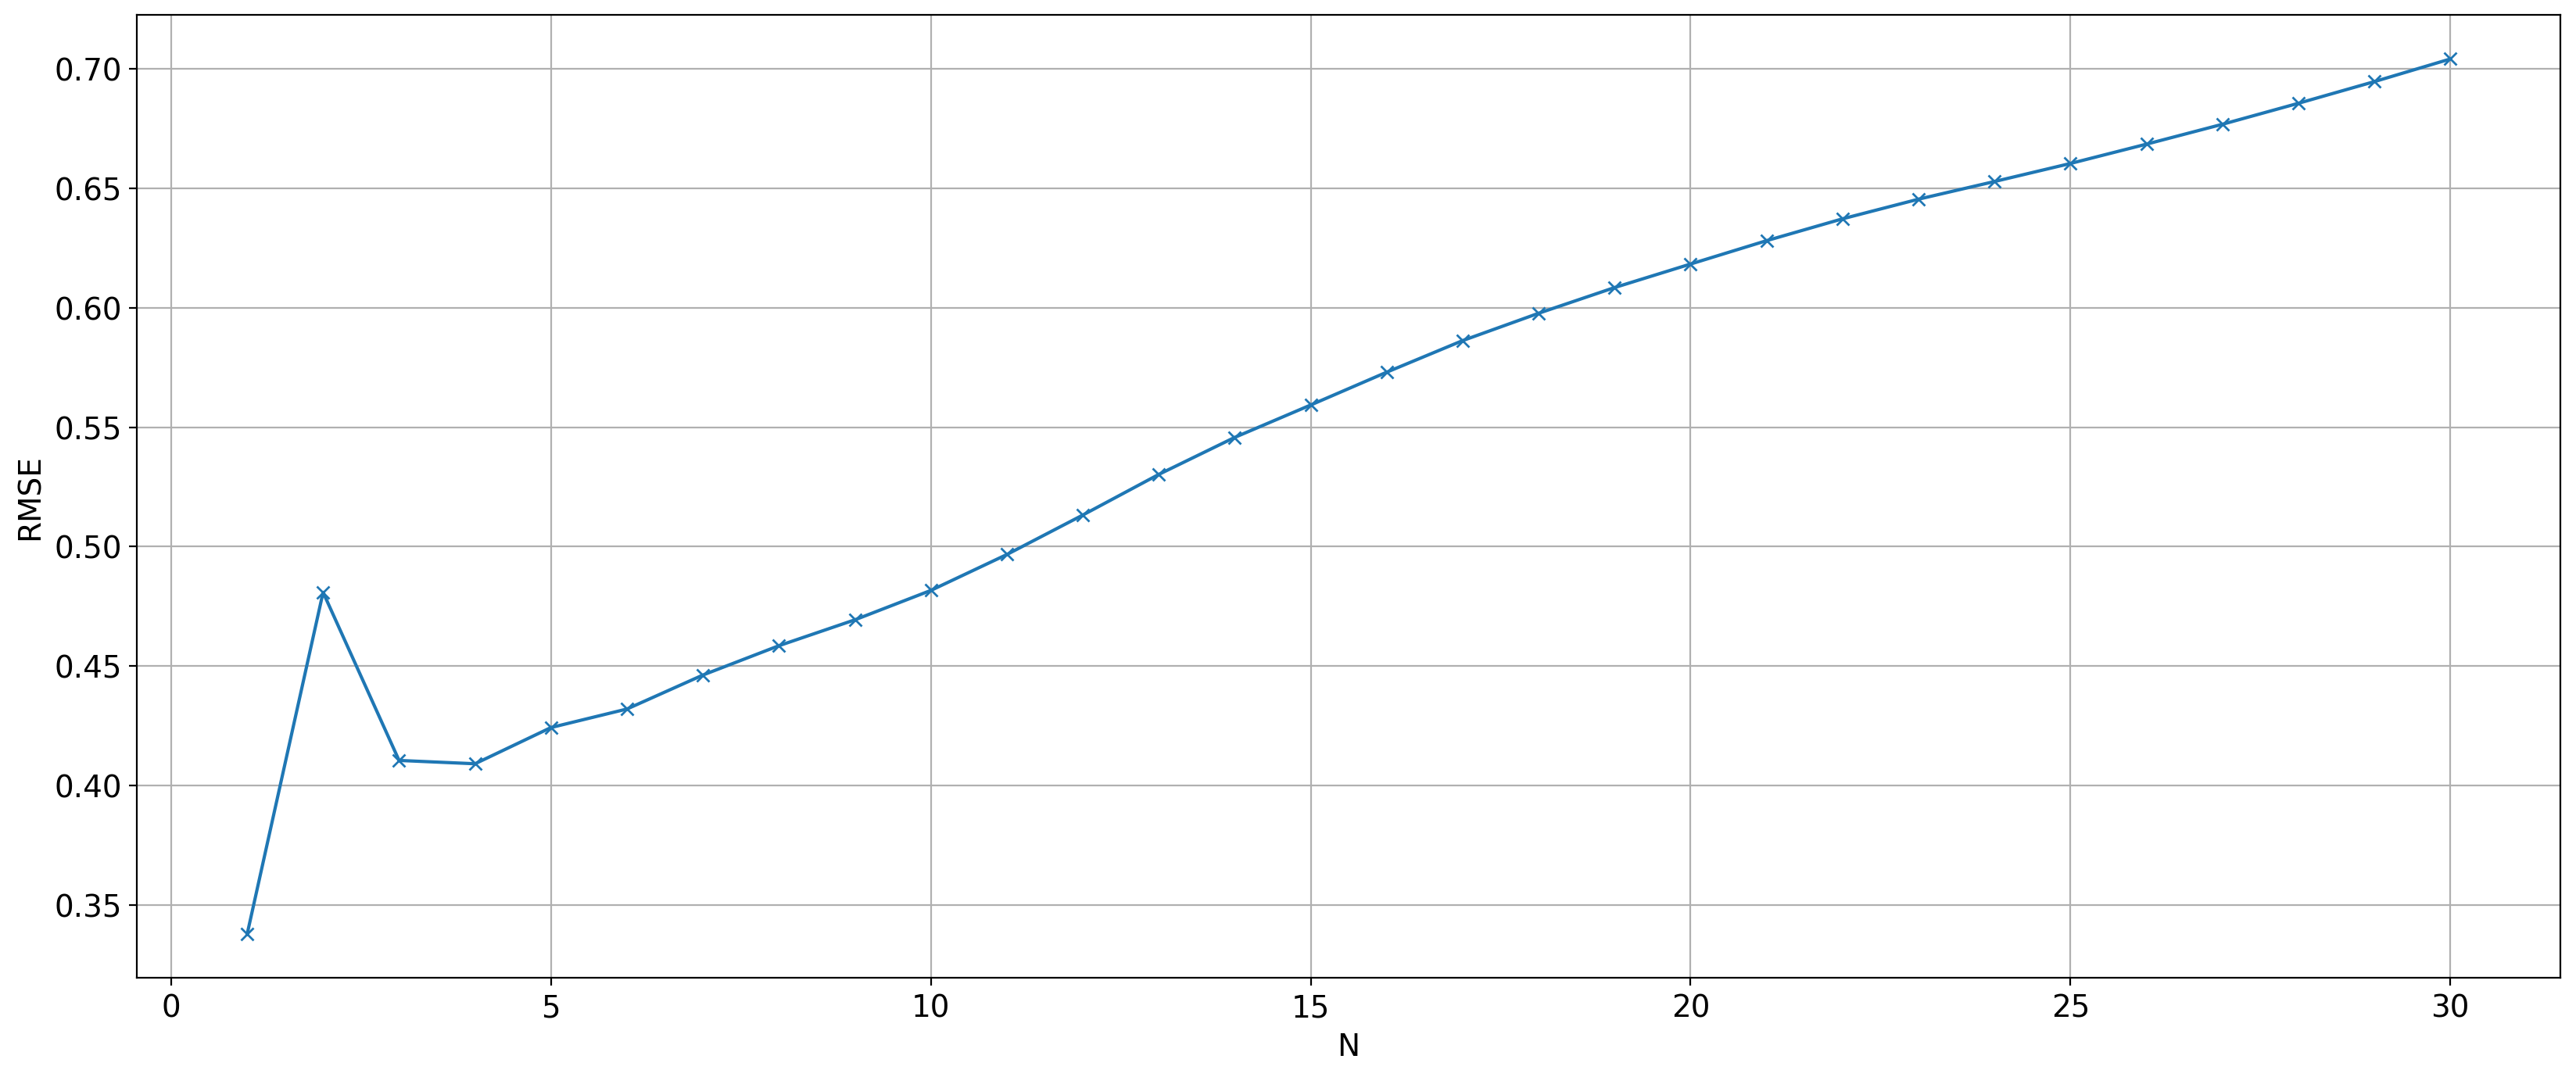

In [32]:
# Plot RMSE versus N
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(20, 8), dpi=200)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
#plt.xlim([2, 30])

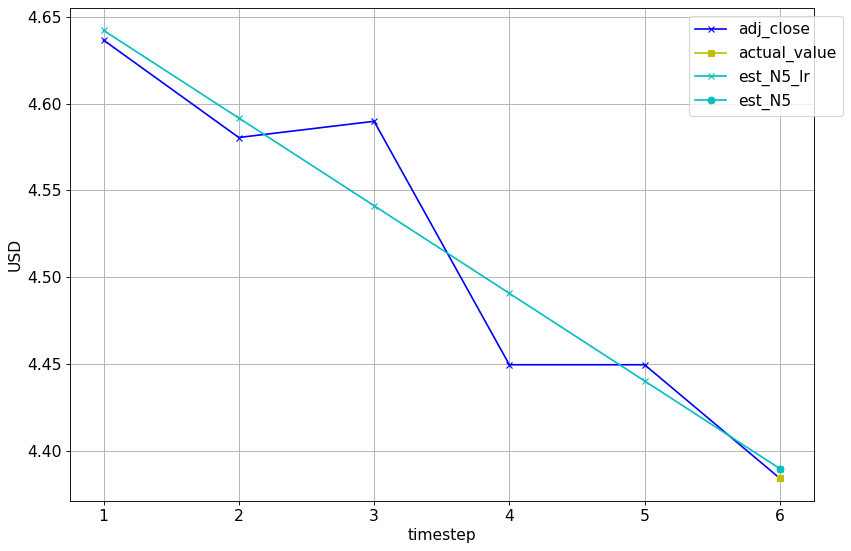

In [35]:
# Specify the day you are interested in
day = pd.Timestamp(date(2018,2,2))

# Specify the maximum N you want to plot (If Nmax2 is too large it gets very cluttered) 
Nmax2 = 5
df_temp = cv[cv['date'] <= day]
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1,Nmax2+2), df_temp[-Nmax2-1:]['adj_close'], 'bx-')
plt.plot(Nmax2+1, df_temp[-1:]['adj_close'], 'ys-')
legend_list = ['adj_close', 'actual_value']
# Plot the linear regression lines and the predictions
color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
marker_list = ['x', 'x', 'x', 'x', 'x', 'x', 'x']
regr = LinearRegression(fit_intercept=True) # Create linear regression object
for N in range(5, Nmax2+1):
    # Plot the linear regression lines
    X_train = np.array(range(len(df_temp['adj_close'][-N-1:-1]))) # e.g. [0 1 2 3 4]
    y_train = np.array(df_temp['adj_close'][-N-1:-1]) # e.g. [2944 3088 3226 3335 3436]
    X_train = X_train.reshape(-1, 1)     
    y_train = y_train.reshape(-1, 1)
    regr.fit(X_train, y_train)            # Train the model
    y_est = regr.predict(X_train)         # Get linear regression line
    plt.plot(range(Nmax2+1-N,Nmax2+2), 
             np.concatenate((y_est, np.array(df_temp['est_N'+str(N)][-1:]).reshape(-1,1))),
             color=color_list[N%len(color_list)], 
             marker=marker_list[N%len(marker_list)])
    legend_list.append('est_N'+str(N)+'_lr')
    
    # Plot the predictions
    plt.plot(Nmax2+1, 
             df_temp['est_N'+str(N)][-1:], 
             color=color_list[N%len(color_list)], 
             marker='o')
    legend_list.append('est_N'+str(N))
plt.grid()
plt.xlabel('timestep')
plt.ylabel('USD')
plt.legend(legend_list, bbox_to_anchor=(1.05, 1))
matplotlib.rcParams.update({'font.size': fontsize})

Text(0, 0.5, 'USD')

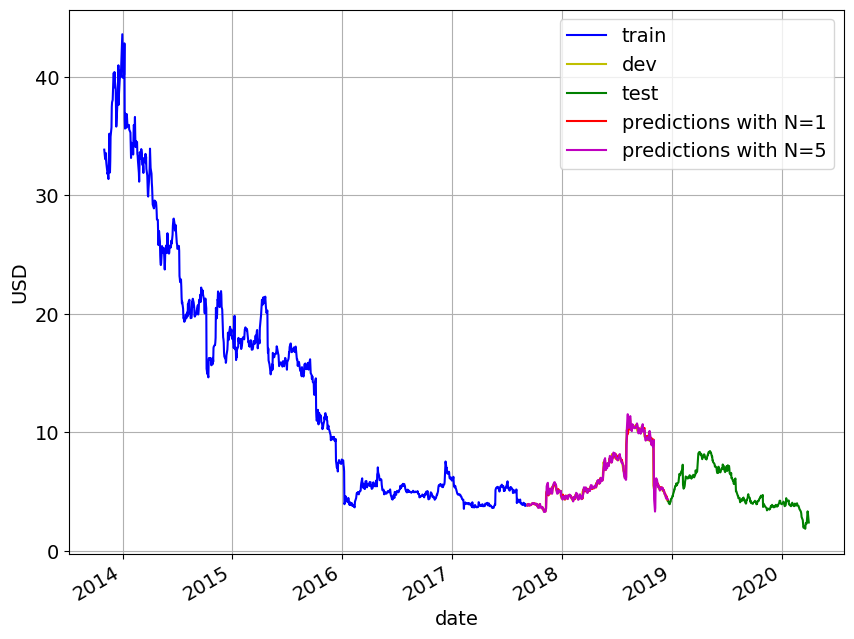

In [37]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='m-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

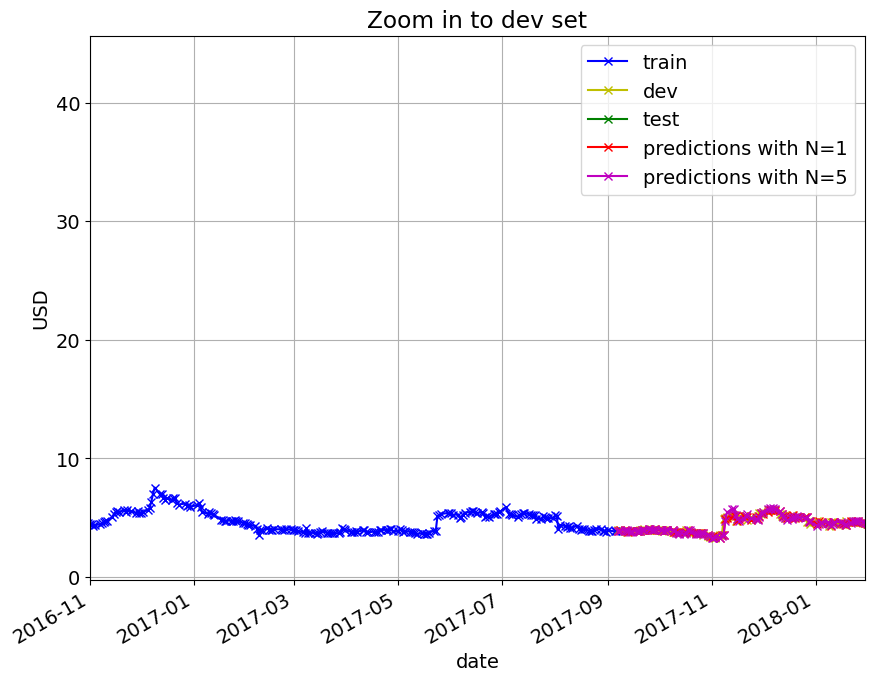

In [38]:
ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2016, 11, 1), date(2018, 1, 30)])
#ax.set_ylim([127, 137])
ax.set_title('Zoom in to dev set')

In [40]:
N_opt = 5

est_list = get_preds_lin_reg(df, 'adj_close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['adj_close'])))
print("R2 = %0.3f" % r2_score(test['adj_close'], est_list))
print("MAPE = %0.3f%%" % get_mape(test['adj_close'], est_list))
test.head()

RMSE = 0.247
R2 = 0.977
MAPE = 3.471%


,open,high,low,close,adj_close,volume,date,month,est_N5
Date,,,,,,,,,
2018-12-18,4.64,4.67,4.47,4.54,4.243913,212700,2018-12-18,12,4.163522
2018-12-19,4.54,4.69,4.48,4.53,4.234565,260000,2018-12-19,12,4.067239
2018-12-20,4.54,4.57,4.32,4.40,4.113044,301200,2018-12-20,12,4.107435
2018-12-21,4.39,4.45,4.27,4.29,4.010217,283500,2018-12-21,12,4.099022
2018-12-24,4.21,4.37,4.21,4.22,3.944782,132200,2018-12-24,12,3.997130


Text(0, 0.5, 'USD')

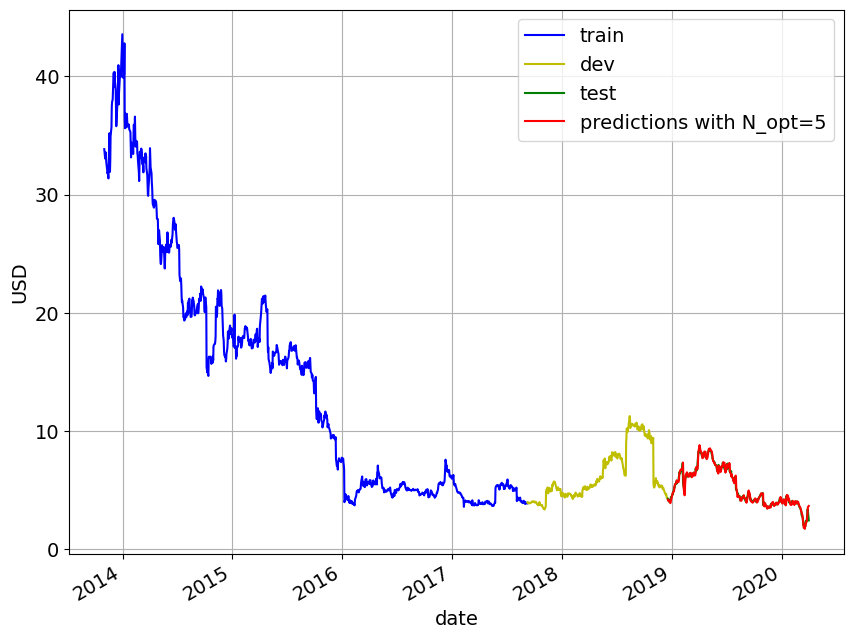

In [41]:
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N5', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

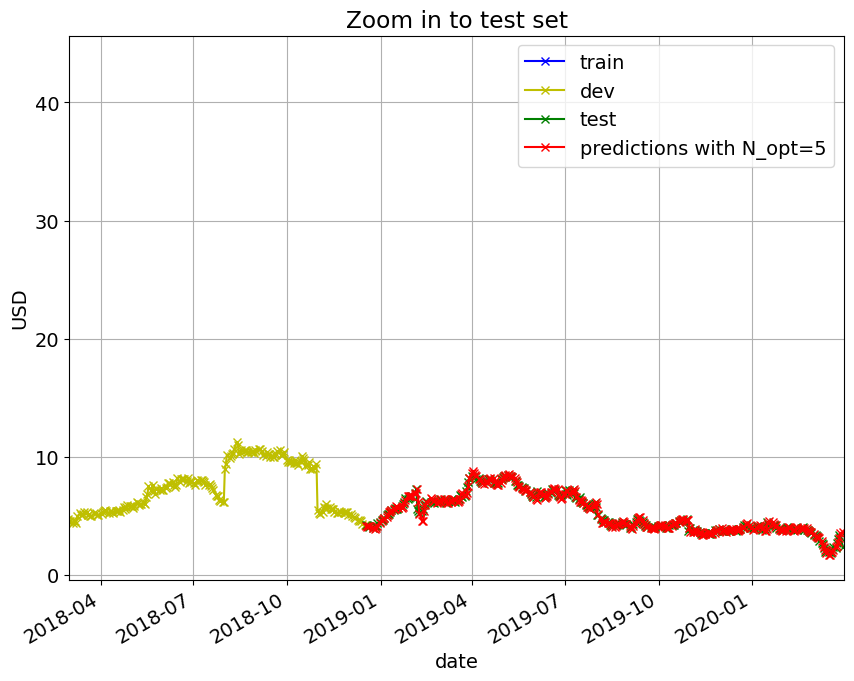

In [42]:
ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N5', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018,3,1), date(2020, 3, 31)])
#ax.set_ylim([135, 150])
ax.set_title('Zoom in to test set')

(17613.0, 18352.0)

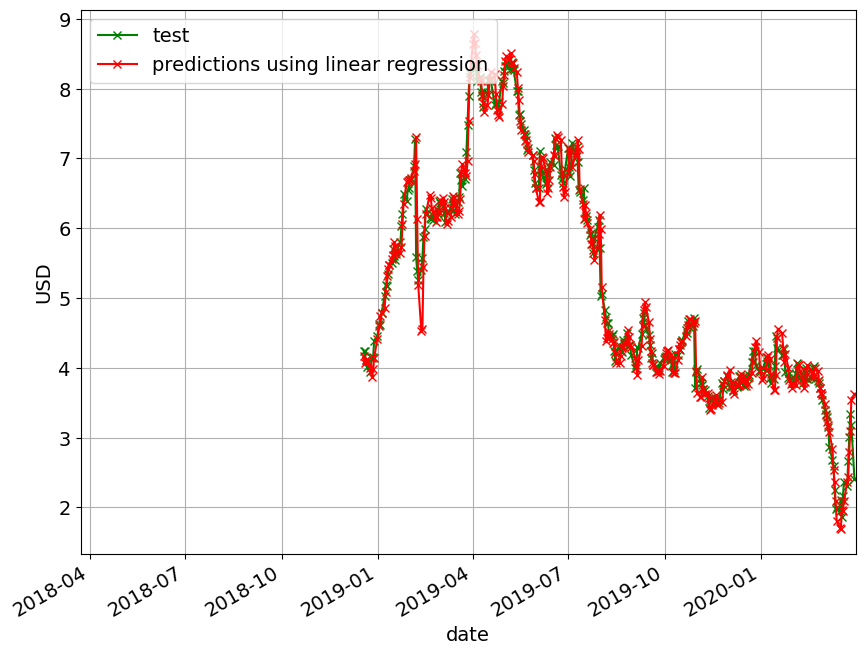

In [43]:
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = test.plot(x='date', y='est_N5', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using linear regression'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 3, 23), date(2020, 3, 31)])
#ax.set_ylim([130, 155])

### **XGBoost Regression**

In [45]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web
import time

from datetime import *
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import *
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
%matplotlib inline
test_size = 0.2                                                # proportion of dataset to be used as test set
cv_size = 0.2                                                   # proportion of dataset to be used as cross-validation set
N = 3                                                              # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
n_estimators = 100                          # Number of boosted trees to fit. default = 100
max_depth = 3                               # Maximum tree depth for base learners. default = 3
learning_rate = 0.1                         # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1                     # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0
model_seed = 100
fontsize = 14
ticklabelsize = 14

In [46]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() 
    std_list = df[col].rolling(window = N, min_periods=1).std()   
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

In [47]:
def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''
    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean
    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [50]:
import yfinance as yf
import pandas as pd

main_company = 'TCS'  # Use only the ticker symbol

start = datetime(2010, 1, 1)
end = datetime(2020, 3, 31)

# Use yfinance to download data
df = yf.download(main_company, start=start, end=end)

# Add a 'date' column with the index (timestamps)
df['date'] = df.index

df=df.reset_index(drop=True)
# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
# Get month of each sample
df['month'] = df['date'].dt.month
# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()


[*********************100%%**********************]  1 of 1 completed


,open,high,low,close,adj_close,volume,date,month
0,35.000000,37.000000,32.099998,36.200001,33.839130,14667600,2013-11-01,11
1,36.799999,36.799999,34.689999,35.349998,33.044563,1586600,2013-11-04,11
2,35.110001,35.500000,34.820000,35.349998,33.044563,337700,2013-11-05,11
3,35.610001,36.490002,35.610001,35.900002,33.558697,549600,2013-11-06,11
4,36.799999,36.799999,34.119999,35.310001,33.007175,883700,2013-11-07,11


Text(0, 0.5, 'USD')

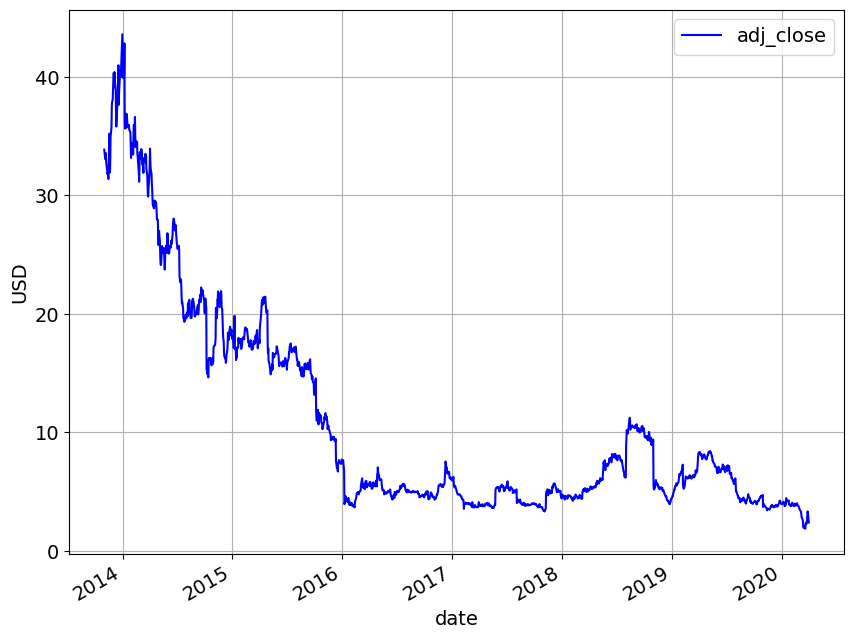

In [51]:
ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [52]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

In [53]:
# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)
df.head()

,adj_close,volume,date,month,range_hl,range_oc
0,33.839130,14667600,2013-11-01,11,4.900002,-1.200001
1,33.044563,1586600,2013-11-04,11,2.110001,1.450001
2,33.044563,337700,2013-11-05,11,0.680000,-0.239998
3,33.558697,549600,2013-11-06,11,0.880001,-0.290001
4,33.007175,883700,2013-11-07,11,2.680000,1.489998


In [54]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]
print(df.head())

   adj_close    volume       date  month  range_hl  range_oc  order_day
0  33.839130  14667600 2013-11-01     11  4.900002 -1.200001          0
1  33.044563   1586600 2013-11-04     11  2.110001  1.450001          1
2  33.044563    337700 2013-11-05     11  0.680000 -0.239998          2
3  33.558697    549600 2013-11-06     11  0.880001 -0.290001          3
4  33.007175    883700 2013-11-07     11  2.680000  1.489998          4


In [55]:
# merging_keys
merging_keys = ['order_day']
# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [57]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)
    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
    
    
    
    
print(train_shift.head())
    
del train_shift
# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

/tmp/ipykernel_59904/429042861.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for shift in tqdm_notebook(shift_range):


  0%|          | 0/3 [00:00<?, ?it/s]

   order_day  adj_close_lag_3  range_hl_lag_3  range_oc_lag_3  volume_lag_3
0          3        33.839130        4.900002       -1.200001      14667600
1          4        33.044563        2.110001        1.450001       1586600
2          5        33.044563        0.680000       -0.239998        337700
3          6        33.558697        0.880001       -0.290001        549600
4          7        33.007175        2.680000        1.489998        883700


,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,33.558697,549600,2013-11-06,11,0.880001,-0.290001,3,33.044563,0.680000,-0.239998,337700.0,33.044563,2.110001,1.450001,1586600.0,33.839130,4.900002,-1.200001,14667600.0
4,33.007175,883700,2013-11-07,11,2.680000,1.489998,4,33.558697,0.880001,-0.290001,549600.0,33.044563,0.680000,-0.239998,337700.0,33.044563,2.110001,1.450001,1586600.0
5,32.670654,488300,2013-11-08,11,0.730000,0.349998,5,33.007175,2.680000,1.489998,883700.0,33.558697,0.880001,-0.290001,549600.0,33.044563,0.680000,-0.239998,337700.0
6,32.006958,430500,2013-11-11,11,1.430000,1.109997,6,32.670654,0.730000,0.349998,488300.0,33.007175,2.680000,1.489998,883700.0,33.558697,0.880001,-0.290001,549600.0
7,31.773262,331400,2013-11-12,11,0.790001,0.549999,7,32.006958,1.430000,1.109997,430500.0,32.670654,0.730000,0.349998,488300.0,33.007175,2.680000,1.489998,883700.0


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609 entries, 3 to 1611
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   adj_close        1609 non-null   float64       
 1   volume           1609 non-null   int64         
 2   date             1609 non-null   datetime64[ns]
 3   month            1609 non-null   int32         
 4   range_hl         1609 non-null   float64       
 5   range_oc         1609 non-null   float64       
 6   order_day        1609 non-null   int64         
 7   adj_close_lag_1  1609 non-null   float64       
 8   range_hl_lag_1   1609 non-null   float64       
 9   range_oc_lag_1   1609 non-null   float64       
 10  volume_lag_1     1609 non-null   float64       
 11  adj_close_lag_2  1609 non-null   float64       
 12  range_hl_lag_2   1609 non-null   float64       
 13  range_oc_lag_2   1609 non-null   float64       
 14  volume_lag_2     1609 non-null   float64

In [59]:
# # Get mean of adj_close of each month
df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
df_gb

,month,adj_close_mean
0,1,11.271975
1,2,10.647035
2,3,10.427546
3,4,12.279802
4,5,10.691503
5,6,11.182410
6,7,10.686553
7,8,9.763769
8,9,9.962867
9,10,8.456574


In [60]:
# # Merge to main df
df = df.merge(df_gb, 
               left_on=['month'], 
            right_on=['month'],
               how='left').fillna(0)
df.head()

,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,adj_close_mean
0,33.558697,549600,2013-11-06,11,0.880001,-0.290001,3,33.044563,0.680000,-0.239998,337700.0,33.044563,2.110001,1.450001,1586600.0,33.839130,4.900002,-1.200001,14667600.0,11.234742
1,33.007175,883700,2013-11-07,11,2.680000,1.489998,4,33.558697,0.880001,-0.290001,549600.0,33.044563,0.680000,-0.239998,337700.0,33.044563,2.110001,1.450001,1586600.0,11.234742
2,32.670654,488300,2013-11-08,11,0.730000,0.349998,5,33.007175,2.680000,1.489998,883700.0,33.558697,0.880001,-0.290001,549600.0,33.044563,0.680000,-0.239998,337700.0,11.234742
3,32.006958,430500,2013-11-11,11,1.430000,1.109997,6,32.670654,0.730000,0.349998,488300.0,33.007175,2.680000,1.489998,883700.0,33.558697,0.880001,-0.290001,549600.0,11.234742
4,31.773262,331400,2013-11-12,11,0.790001,0.549999,7,32.006958,1.430000,1.109997,430500.0,32.670654,0.730000,0.349998,488300.0,33.007175,2.680000,1.489998,883700.0,11.234742


In [61]:
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

In [62]:
for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()
df.columns

Index(['adj_close', 'volume', 'date', 'month', 'range_hl', 'range_oc',
       'order_day', 'adj_close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1',
       'volume_lag_1', 'adj_close_lag_2', 'range_hl_lag_2', 'range_oc_lag_2',
       'volume_lag_2', 'adj_close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3',
       'volume_lag_3', 'adj_close_mean', 'adj_close_std', 'range_hl_mean',
       'range_hl_std', 'range_oc_mean', 'range_oc_std', 'volume_mean',
       'volume_std'],
      dtype='object')

In [63]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

num_train = 967
num_cv = 321
num_test = 321


In [64]:
# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

train.shape = (967, 27)
cv.shape = (321, 27)
train_cv.shape = (1288, 27)
test.shape = (321, 27)


In [66]:
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))
# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))
# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [1.40719876e+01 1.41020708e+01 6.81158255e-01 3.36814166e-02
 3.88237332e+05 1.41321830e+01 6.83236849e-01 3.52429478e-02
 3.89760910e+05 1.41632038e+01 6.88138609e-01 3.39606306e-02
 4.04785109e+05]
scaler.var_ = [1.04398494e+02 1.04663967e+02 3.52747442e-01 3.05347576e-01
 3.20678648e+11 1.04927039e+02 3.54505113e-01 3.07410479e-01
 3.22083237e+11 1.05218192e+02 3.72585871e-01 3.08986708e-01
 5.32606123e+11]
train_scaled.shape = (967, 13)
train_scaled.shape = (967, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,1.907179,1.851563,-0.001950,-0.495273,-0.089244,1.846301,2.396298,2.551660,2.108879,1.918182,6.900190,-2.219891,19.543492,2013-11-06,11
1,1.853201,1.901818,0.334794,-0.585763,0.284950,1.846301,-0.005436,-0.496425,-0.091733,1.840720,2.329401,2.547450,1.619371,2013-11-07,11
2,1.820265,1.847909,3.365476,2.635473,0.874935,1.896493,0.330472,-0.586610,0.281643,1.840720,-0.013333,-0.492850,-0.091923,2013-11-08,11
3,1.755309,1.815015,0.082235,0.572434,0.176700,1.842651,3.353632,2.623799,0.870341,1.890843,0.314323,-0.582805,0.198431,2013-11-11,11
4,1.732437,1.750141,1.260835,1.947791,0.074631,1.809798,0.078540,0.567694,0.173630,1.837076,3.263217,2.619405,0.656229,2013-11-12,11


In [67]:
# Do scaling for dev set
cv_scaled = cv[['date','adj_close']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

/tmp/ipykernel_59904/267691958.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(cols_list):


  0%|          | 0/4 [00:00<?, ?it/s]

,date,adj_close,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
967,2017-09-11,3.907391,0.800641,0.320256,-1.120897,0.704363,-1.144586,0.440222,-0.259831,-0.844439,1.104270,0.989913,-1.009791,0.019878
968,2017-09-12,3.832609,-0.927172,1.059626,-0.132455,-0.844439,1.104270,-0.259831,1.104270,-0.259831,-0.844439,-0.559876,1.154526,-0.594650
969,2017-09-13,3.879348,-1.067490,0.152499,0.914991,0.783525,-1.126314,0.342790,0.898026,0.179606,-1.077632,0.845053,-1.104006,0.258953
970,2017-09-14,3.879348,0.164961,-1.072223,0.907262,0.152492,0.914995,-1.067488,-1.109400,0.832050,0.277350,0.574888,0.579809,-1.154697
971,2017-09-15,3.879348,0.577350,0.577350,-1.154701,-0.960983,-0.073931,1.034914,0.094916,-1.044074,0.949158,-1.154347,0.552438,0.601910


In [68]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

scaler_train_cv.mean_ = [1.21310835e+01 1.21534442e+01 5.93579219e-01 2.45496381e-02
 3.61802019e+05 1.21758195e+01 5.95038847e-01 2.55977754e-02
 3.62720885e+05 1.21987246e+01 5.98555929e-01 2.45263460e-02
 3.73834627e+05]
scaler_train_cv.var_ = [9.09274594e+01 9.12182375e+01 3.02275994e-01 2.43338941e-01
 2.91888787e+11 9.15077850e+01 3.03956584e-01 2.44910993e-01
 2.93051315e+11 9.18239204e+01 3.18293641e-01 2.46057556e-01
 4.51801615e+11]
train_cv_scaled.shape = (1288, 13)


In [69]:
# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

train_cv_scaled.shape = (1288, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,2.247120,2.187363,0.157187,-0.536288,-0.044611,2.181561,2.747868,2.878251,2.260824,2.258330,7.624308,-2.468596,21.265361,2013-11-06,11
1,2.189282,2.241194,0.520960,-0.637653,0.347602,2.181561,0.154105,-0.536682,-0.046220,2.175412,2.679034,2.873698,1.804276,2013-11-07,11
2,2.153991,2.183448,3.794898,2.970740,0.966000,2.235307,0.516870,-0.637721,0.345214,2.175412,0.144360,-0.533270,-0.053759,2013-11-08,11
3,2.084389,2.148214,0.248129,0.659746,0.234140,2.177652,3.781745,2.959073,0.962384,2.229065,0.498861,-0.634074,0.261493,2013-11-11,11
4,2.059881,2.078723,1.521329,2.200406,0.127156,2.142473,0.244794,0.655507,0.231977,2.171510,3.689358,2.954330,0.758545,2013-11-12,11


In [70]:
# Do scaling for test set
test_scaled = test[['date','adj_close']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

/tmp/ipykernel_59904/4186549157.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(cols_list):


  0%|          | 0/4 [00:00<?, ?it/s]

,date,adj_close,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1288,2018-12-19,4.234565,-0.414779,-0.725867,1.140647,-0.734717,-0.404096,1.138814,-0.577350,-0.577350,1.154701,-1.117055,0.811789,0.305265
1289,2018-12-20,4.113044,0.000000,1.000000,-1.000000,-0.218225,-0.872867,1.091092,-1.154701,0.577350,0.577350,-0.322118,-0.799243,1.121361
1290,2018-12-21,4.010217,-1.152332,0.512147,0.640185,1.133894,-0.377969,-0.755926,0.851064,-1.101378,0.250314,0.976252,0.045915,-1.022166
1291,2018-12-24,3.944782,-0.971100,-0.055489,1.026589,-0.949159,1.044073,-0.094913,0.250314,0.851064,-1.101378,0.093543,0.949942,-1.043485
1292,2018-12-26,4.141087,-0.918397,-0.146946,1.065342,-0.775880,-0.352673,1.128553,-1.115767,0.300398,0.815368,-1.149447,0.479445,0.670003


In [71]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

In [72]:
target = "adj_close"
print(features)
# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

['adj_close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1', 'volume_lag_1', 'adj_close_lag_2', 'range_hl_lag_2', 'range_oc_lag_2', 'volume_lag_2', 'adj_close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3', 'volume_lag_3']
X_train.shape = (967, 12)
y_train.shape = (967,)
X_cv.shape = (321, 12)
y_cv.shape = (321,)
X_train_cv.shape = (1288, 12)
y_train_cv.shape = (1288,)
X_sample.shape = (321, 12)
y_sample.shape = (321,)


In [73]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled['adj_close']
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled['adj_close']
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (967, 12)
y_train_scaled.shape = (967,)
X_cv_scaled.shape = (321, 12)
X_train_cv_scaled.shape = (1288, 12)
y_train_cv_scaled.shape = (1288,)
X_sample_scaled.shape = (321, 12)


Text(0.5, 1.0, 'Without scaling')

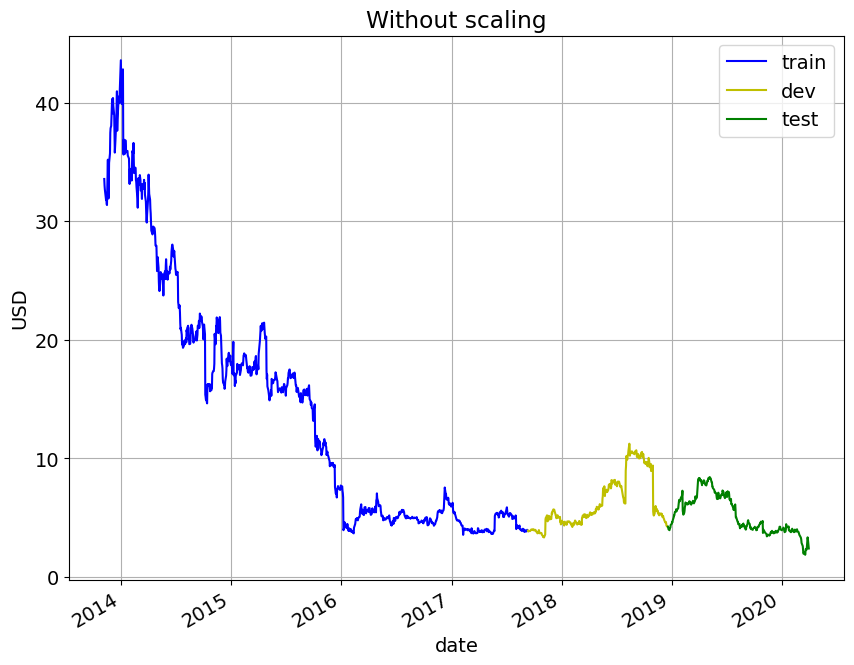

In [74]:
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

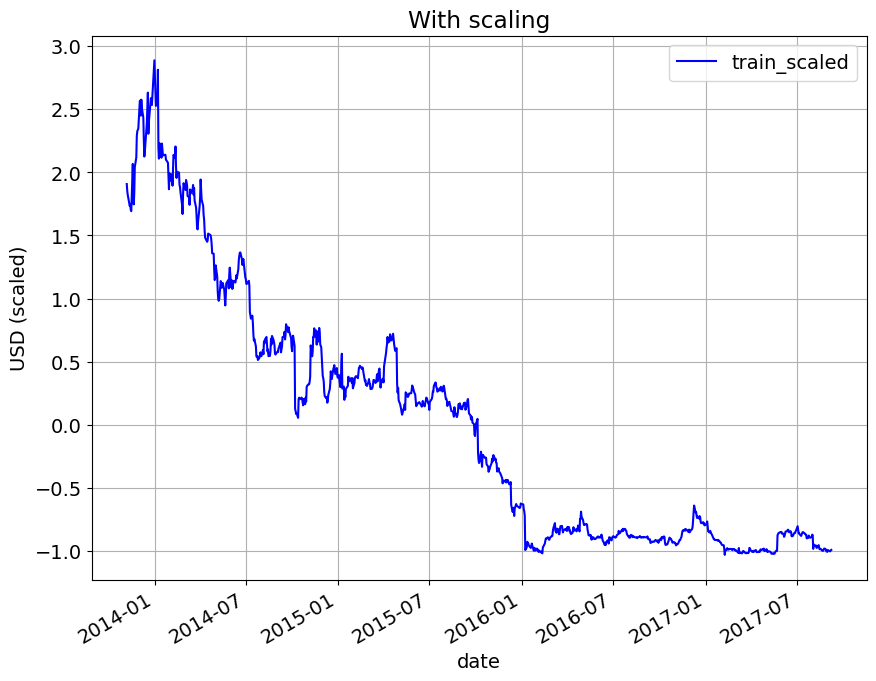

In [75]:
ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

In [76]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

In [77]:
# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

/home/proci/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/proci/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/proci/anaconda3/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/proci/anaconda3/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float 

XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=1,
             colsample_bynode=None, colsample_bytree=1, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [80]:
est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

NameError: name 'est' is not defined